# TASK - 0

In [97]:
# Fix for OpenMP library conflict
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [98]:
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import random
import time

from tqdm import tqdm

from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms as T
from torchvision.utils import make_grid

from PIL import Image

In [99]:
transform = T.ToTensor()

# Loading MNIST
train_data = datasets.MNIST(root='./Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./Data', train=False, download=True, transform=transform)

In [100]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [101]:
# Creating a color-digit mapping with maximally distinct colors
color_digit_map = {
    0: (255, 0, 0),       # Red
    1: (0, 255, 0),       # Green
    2: (0, 0, 255),       # Blue
    3: (255, 255, 0),     # Yellow
    4: (0, 255, 255),     # Cyan
    5: (255, 0, 255),     # Magenta
    6: (255, 128, 0),     # Orange
    7: (255, 255, 255),   # White
    8: (128, 0, 255),     # Purple
    9: (128, 255, 0),     # Lime
}

In [102]:
p_bias = 0.95  # Probability of applying color bias
# 95% - Dominant color
# 5% - Random color

In [103]:
def apply_color(image, label, train_mode):
    # Convert tensor to numpy array
    image_np = image.numpy().squeeze() * 255  # Scale to [0, 255]
    image_np = image_np.astype(np.uint8)

    # Create a 3-channel RGB image
    rgb_image = np.zeros((28, 28, 3), dtype=np.uint8)

    # Decide if we apply bias
    if train_mode:
        biased = random.random() < p_bias
    else:
        biased = False  # In test mode, we do not apply bias

    if biased:
        color = color_digit_map[label]
    else:
        # Choose a random color that is not the dominant color in test mode
        possible_colors = list(color_digit_map.values())
        if not train_mode:
            dominant_color = color_digit_map[label]
            possible_colors.remove(dominant_color)
        color = random.choice(possible_colors)

    # Apply color to the BACKGROUND, keep digit stroke white
    threshold = 50
    bg_mask = image_np <= threshold   # Background pixels
    fg_mask = image_np > threshold    # Digit stroke pixels

    # Fill background with the bias color
    rgb_image[bg_mask] = color
    # Keep digit stroke as white
    rgb_image[fg_mask] = (255, 255, 255)

    return Image.fromarray(rgb_image)

In [104]:
def stroke_based_coloring(dataset, train_mode=True):
    colored_data = []
    to_tensor = T.ToTensor()
    for image, label in dataset:
        colored_image = apply_color(image, label, train_mode)
        colored_data.append((to_tensor(colored_image), label))
    return colored_data

In [105]:
# Creating biased training dataset
biased_train_data = stroke_based_coloring(train_data, train_mode=True)

# Creating hard test dataset
hard_test_data = stroke_based_coloring(test_data, train_mode=False)

In [106]:
def visualize_samples(biased_data, hard_data):
    fig, axes = plt.subplots(4, 10, figsize=(15, 6))
    
    # Plot biased training samples
    for i in range(20):
        ax = axes[i // 10, i % 10]
        ax.imshow(biased_data[i][0].permute(1, 2, 0))  # CxHxW -> HxWxC
        ax.set_title(f'Train: {biased_data[i][1]}')
        ax.axis('off')
    
    # Plot hard test samples
    for i in range(20):
        ax = axes[(i // 10) + 2, i % 10]
        ax.imshow(hard_data[i][0].permute(1, 2, 0))  # CxHxW -> HxWxC
        ax.set_title(f'Test: {hard_data[i][1]}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

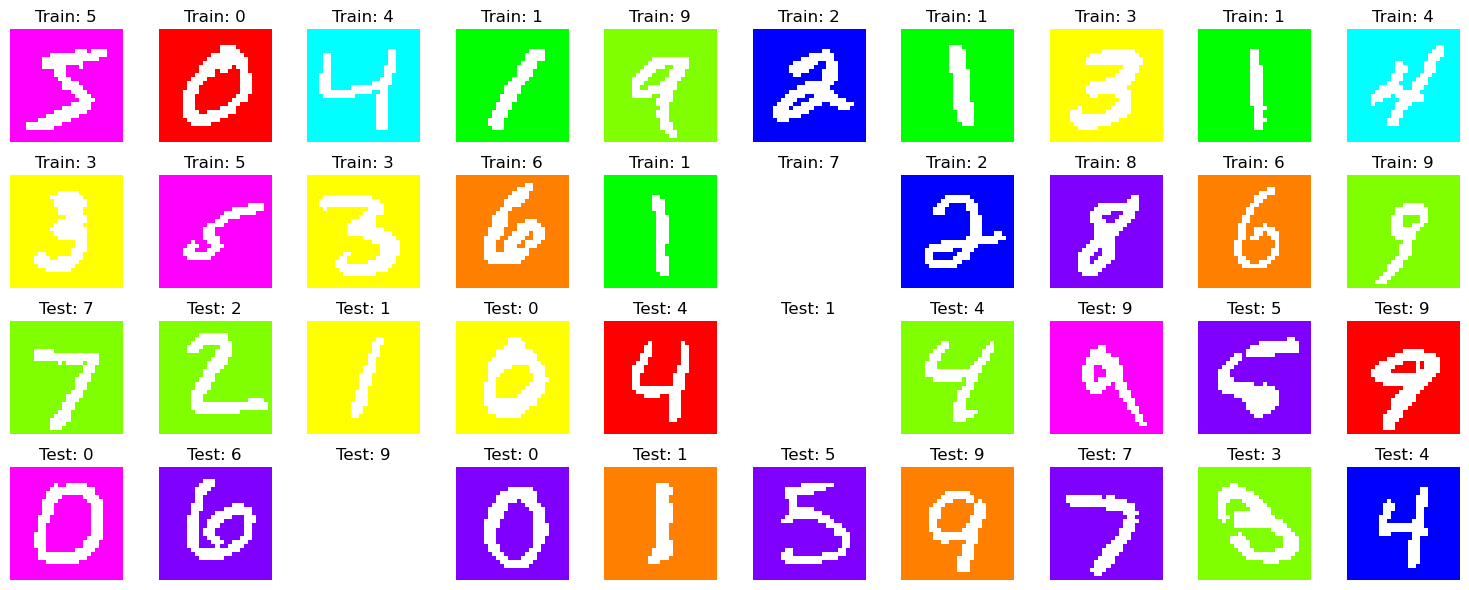

In [107]:
visualize_samples(biased_train_data, hard_test_data)

In [108]:
# Images are already tensors, so default collate works
# Just need to convert labels to tensor
def collate_fn(batch):
    images = torch.stack([item[0] for item in batch])
    labels = torch.tensor([item[1] for item in batch])
    return images, labels

In [109]:
train_loader = DataLoader(
    biased_train_data, 
    batch_size=64, 
    shuffle=True, 
    collate_fn=collate_fn
)

test_loader = DataLoader(
    hard_test_data, 
    batch_size=64, 
    shuffle=False, 
    collate_fn=collate_fn
)

train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x1dc3fde17e0>,
 <torch.utils.data.dataloader.DataLoader at 0x1dc3fde0610>)

In [110]:
class_names = [str(i) for i in range(10)]

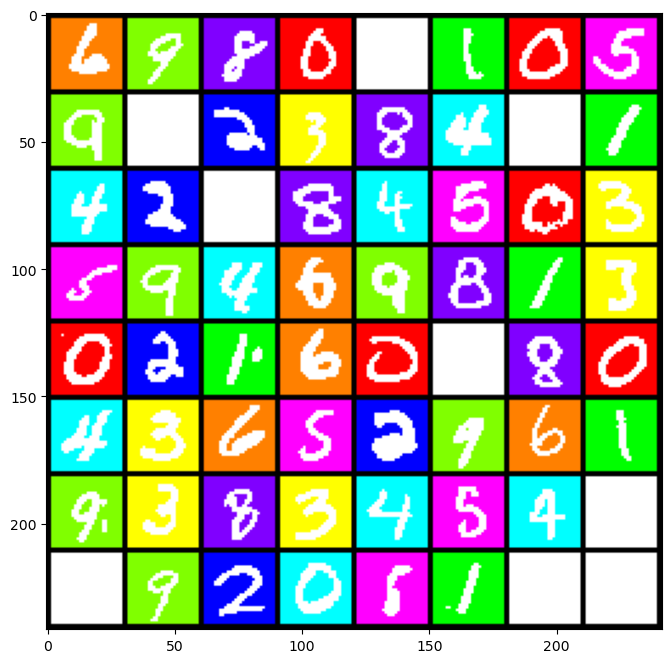

In [111]:
for images,labels in train_loader: 
    break

im = make_grid(images, nrow=8)
plt.figure(figsize=(8,8))

plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

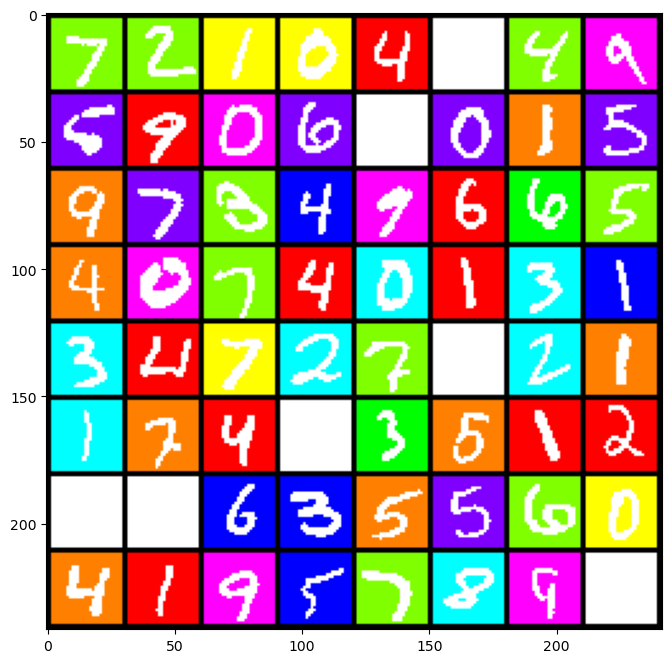

In [112]:
for images,labels in test_loader: 
    break

im = make_grid(images, nrow=8)
plt.figure(figsize=(8,8))

plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

# TASK - 1

In [113]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64*7*7)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [114]:
class LazyCNN(nn.Module):
    def __init__(self):
        super(LazyCNN, self).__init__()
        
        # SINGLE convolutional layer (very important)
        self.conv1 = nn.Conv2d(
            in_channels=3,    # RGB input
            out_channels=16,  # deliberately small
            kernel_size=3,
            padding=1
        )
        
        # Global Average Pooling collapses spatial dims to 1x1
        # This destroys shape information, forcing reliance on color
        self.gap = nn.AdaptiveAvgPool2d(1)
        
        # Minimal classifier head (only 16 features - just color info)
        self.fc = nn.Linear(16, 10)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))   # 28x28 x 16
        x = self.gap(x)                # 1x1 x 16 (all spatial info gone)
        x = x.view(x.size(0), -1)     # Flatten to 16 features
        x = self.fc(x)
        return x

In [115]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if device.type == 'cuda':
    print(f'GPU: {torch.cuda.get_device_name(0)}')

model = LazyCNN().to(device)

Using device: cuda
GPU: NVIDIA GeForce RTX 5060 Laptop GPU


In [116]:
model

LazyCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (gap): AdaptiveAvgPool2d(output_size=1)
  (fc): Linear(in_features=16, out_features=10, bias=True)
  (relu): ReLU()
)

In [117]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

training_time = time.time() - start_time
print(f'Total training time: {training_time:.2f}s')

# Evaluate on easy training set
model.eval()
correct_train = 0
total_train = 0
all_labels_easy = []
all_preds_easy = []
with torch.no_grad():
    for images, labels in tqdm(train_loader, desc='Testing on Easy dataset'):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        all_labels_easy.extend(labels.cpu().numpy())
        all_preds_easy.extend(predicted.cpu().numpy())
        
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
print(f'Accuracy on easy train set: {100 * correct_train / total_train:.2f}%')

# Evaluate on hard test set
correct = 0
total = 0
all_labels_hard = []
all_preds_hard = []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Testing on Hard dataset'):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        all_labels_hard.extend(labels.cpu().numpy())
        all_preds_hard.extend(predicted.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy on hard test set: {100 * correct / total:.2f}%')

Epoch 1/5: 100%|███████████████████████████████████████████████████████████████████| 938/938 [00:06<00:00, 137.65it/s]


Epoch [1/5], Loss: 0.8569


Epoch 2/5: 100%|███████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 128.14it/s]


Epoch [2/5], Loss: 0.4130


Epoch 3/5: 100%|███████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 122.06it/s]


Epoch [3/5], Loss: 0.3548


Epoch 4/5: 100%|███████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 123.32it/s]


Epoch [4/5], Loss: 0.3329


Epoch 5/5: 100%|███████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 121.40it/s]


Epoch [5/5], Loss: 0.3245
Total training time: 37.20s


Testing on Easy dataset: 100%|█████████████████████████████████████████████████████| 938/938 [00:03<00:00, 249.27it/s]


Accuracy on easy train set: 95.49%


Testing on Hard dataset: 100%|█████████████████████████████████████████████████████| 157/157 [00:00<00:00, 266.11it/s]

Accuracy on hard test set: 0.00%


In [118]:
# Show the Confusion Matrix.

def plot_confusion_matrix(all_labels, all_preds, type):
    cm = confusion_matrix(all_labels, all_preds)
    df_cm = pd.DataFrame(cm, class_names, class_names)
    
    plt.figure(figsize=(9, 6))
    sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
    plt.xlabel("Prediction")
    plt.ylabel("Label (ground truth)")
    plt.title(f"Confusion Matrix - {type} Test Set")
    plt.show();

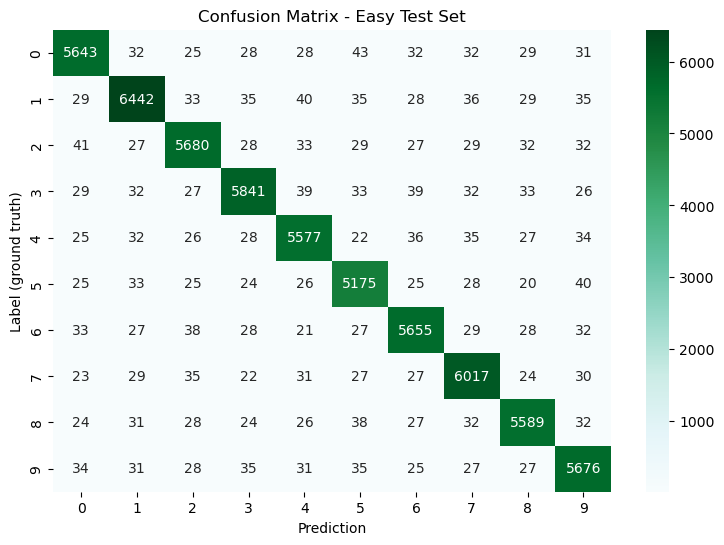

In [119]:
plot_confusion_matrix(all_labels_easy, all_preds_easy, 'Easy')

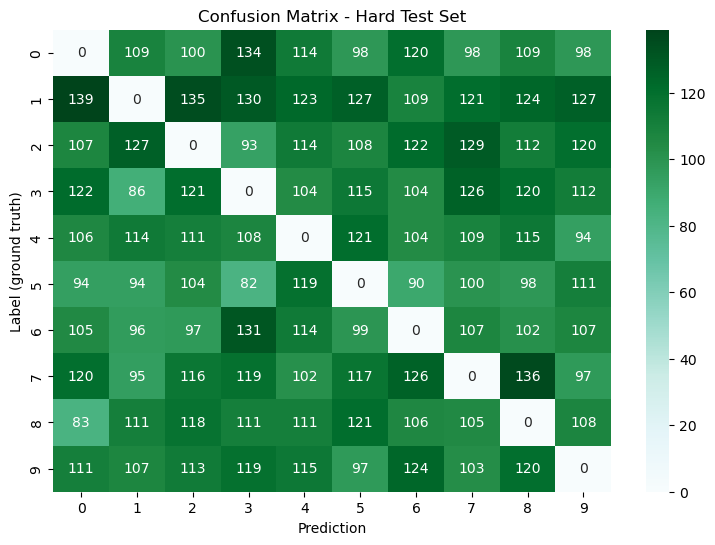

In [120]:
plot_confusion_matrix(all_labels_hard, all_preds_hard, 'Hard')

In [121]:
biased_train_data[0]

(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 5)

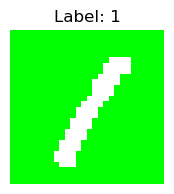

True Label: 1, Model Prediction: 1


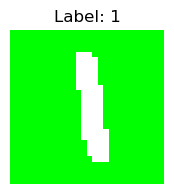

True Label: 1, Model Prediction: 1


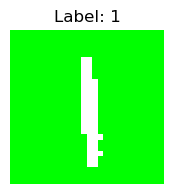

True Label: 1, Model Prediction: 1


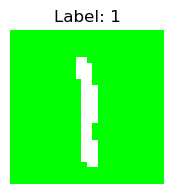

True Label: 1, Model Prediction: 1


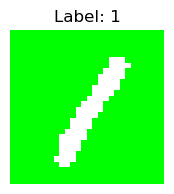

True Label: 1, Model Prediction: 1


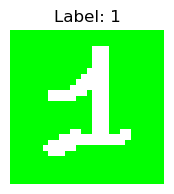

True Label: 1, Model Prediction: 1


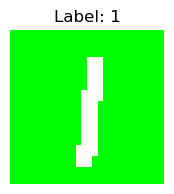

True Label: 1, Model Prediction: 1


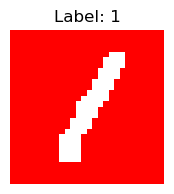

True Label: 1, Model Prediction: 0


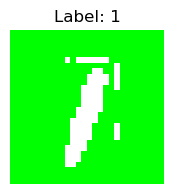

True Label: 1, Model Prediction: 1


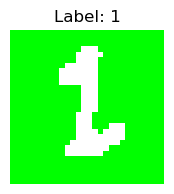

True Label: 1, Model Prediction: 1


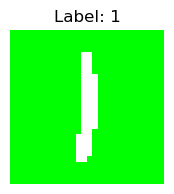

True Label: 1, Model Prediction: 1


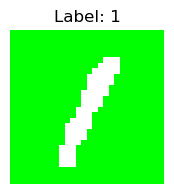

True Label: 1, Model Prediction: 1


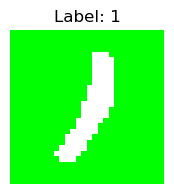

True Label: 1, Model Prediction: 1


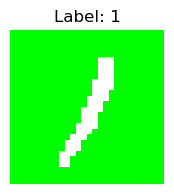

True Label: 1, Model Prediction: 1


In [122]:
# Prove that the model is looking at color. Feed it a Red 1. Does it predict 0?

for idx, (image, label) in enumerate(biased_train_data):
    if label == 1:
        # Display the image
        plt.figure(figsize=(2,2))
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f'Label: {label}')
        plt.axis('off')
        plt.show()
        
        # Get model prediction
        model.eval()
        with torch.no_grad():
            input_tensor = image.unsqueeze(0).to(device)  # Add batch dimension
            output = model(input_tensor)
            _, predicted = torch.max(output, 1)
            print(f'True Label: {label}, Model Prediction: {predicted.item()}')

    if (idx == 100):
        break;

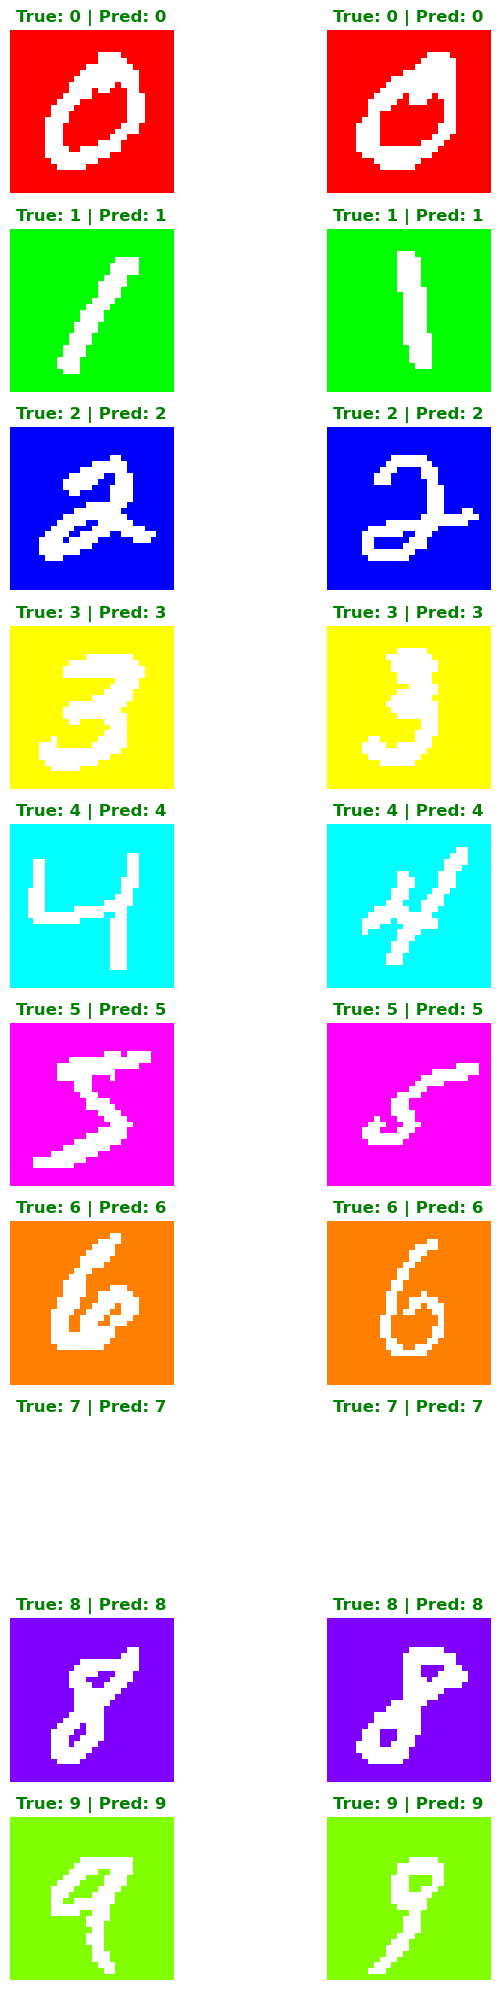

In [123]:
# Prove that the model is looking at color by showing multiple examples

model.eval()
examples_per_digit = 2
fig, axes = plt.subplots(10, examples_per_digit, figsize=(4*examples_per_digit, 20))

digit_counts = {i: 0 for i in range(10)}

with torch.no_grad():
    for idx, (image, label) in enumerate(biased_train_data):
        if digit_counts[label] < examples_per_digit:
            row = label
            col = digit_counts[label]
            
            # Display the image
            ax = axes[row, col] if examples_per_digit > 1 else axes[row]
            ax.imshow(image.permute(1, 2, 0))
            
            # Get model prediction
            input_tensor = image.unsqueeze(0).to(device)
            output = model(input_tensor)
            _, predicted = torch.max(output, 1)
            pred = predicted.item()
            
            # Color the title based on correctness
            color = 'green' if pred == label else 'red'
            ax.set_title(f'True: {label} | Pred: {pred}', color=color, fontweight='bold')
            ax.axis('off')
            
            digit_counts[label] += 1
        
        # Check if we have enough examples for all digits
        if all(count >= examples_per_digit for count in digit_counts.values()):
            break

plt.tight_layout()
plt.show()